In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random

from shapely.geometry import Point, LineString, Polygon
from shapely.ops import unary_union

Design an arbitrary domain

(-0.1, 1.1)

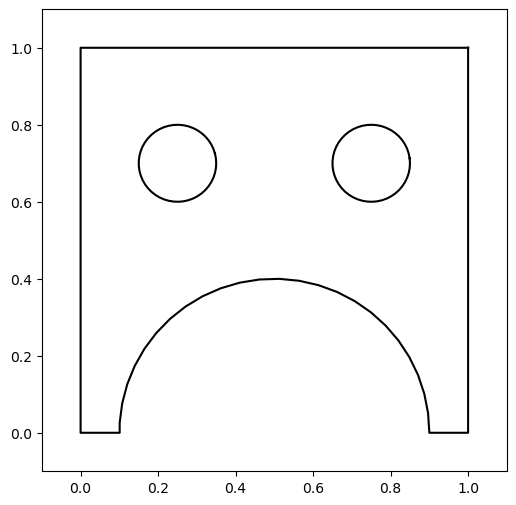

In [8]:
#define a domain line segment list
box_size = 1.0
domain_lines = [
    ((0, 0), (box_size, 0)),
    ((box_size, 0), (box_size, box_size)),
    ((box_size, box_size), (0, box_size)),
    ((0, box_size), (0, 0))
]

#add a cricle in the middle
radius1 = 0.4
thickness = 0 
center_x, center_y = 0.5, 0
resolution = 50
angles = np.linspace(0, 2*np.pi, resolution)
circle_1 = [((radius1 - thickness) * np.cos(angle) + center_x, (radius1 - thickness) * np.sin(angle) + center_y) for angle in angles]

radius2 = 0.1
center_x, center_y = 0.25, 0.7
circle_2 = [((radius2 - thickness) * np.cos(angle) + center_x, (radius2 - thickness) * np.sin(angle) + center_y) for angle in angles]

radius3 = 0.1
center_x, center_y = 0.75, 0.7
circle_3 = [((radius3 - thickness) * np.cos(angle) + center_x, (radius3 - thickness) * np.sin(angle) + center_y) for angle in angles]

box_size = 1.0
box = Polygon([(0,0), (box_size,0), (box_size,box_size), (0,box_size)])
d1= Polygon(circle_1)
d2= Polygon(circle_2)
d3= Polygon(circle_3)

domain_polygon = box.difference(d1).difference(d2).difference(d3)
#keep the largest polygon only
#domain_polygon = max(domain_polygon.geoms, key=lambda a: a.area)

plt.figure(figsize=(6,6))
#plot domain polygon with the interior holes    
x,y = domain_polygon.exterior.xy
plt.plot(x, y, color='black', alpha = 1)
for interior in domain_polygon.interiors:
    x,y = interior.xy
    plt.plot(x, y, color='black', alpha = 1)

plt.xlim(-0.1, box_size+0.1)
plt.ylim(-0.1, box_size+0.1)

Generate the SR system

In [12]:

def generate_line(point, angle, length=1, uni_direction=False):
    """Generate 2D line defined by a point and one angles
    """
    # Convert angles from degrees to radians
    angle_rad = np.radians(angle)

    # Calculate the direction vector using spherical coordinates
    direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])

    # Calculate the start and end points of the line
    if uni_direction:
        start_point = point
    else:
        start_point = point - (length / 2) * direction

    end_point = point + (length / 2) * direction

    return start_point, end_point

def get_a_polygon(line, thickness):
    x1, y1 = line[0]
    x2, y2 = line[1]
    #get a points t distance from line end points on the line
    p1 = Point(x1, y1)
    p2 = Point(x2, y2)

    #get normal vector to the line from p1
    n = np.array([y2-y1, x1-x2])
    n = n/np.linalg.norm(n)
    p1_up = np.array(p1.coords[0]) + thickness*n/2
    p1_down = np.array(p1.coords[0]) - thickness*n/2
        
    p2_up = np.array(p2.coords[0]) + thickness*n/2
    p2_down = np.array(p2.coords[0]) - thickness*n/2

    #define a polygon with p1, p1_up, p2_up, p2, p2_down, p1_down
    polygon = Polygon([p1_up, p2_up, p2_down, p1_down])
        
    #order polygon vertices to generate a convex polygon
    polygon = Polygon(polygon.exterior.coords[:])

    return polygon

def in_domain(point, domain_polygon, polygon_list, distance=0):
    #check if the point is inside the domain polygon
    if not domain_polygon.contains(point):
        return False
    for p in polygon_list:
        # use the local 'point' variable passed into the function
        if point.distance(p) < distance: #p.contains(point):
            return False
    return True
def generate_random_point(domain_polygon, polygon_list, distance, box_size = 1, trial = 100):
    point = np.array([random.uniform(0, box_size), random.uniform(0, box_size)])
    nucleation_point = Point(point[0], point[1])

    good_point = in_domain(nucleation_point, domain_polygon, polygon_list, distance=distance)

    while not good_point and trial > 0:
        point = np.array([random.uniform(0, box_size), random.uniform(0, box_size)])
        nucleation_point = Point(point[0], point[1])
        good_point = in_domain(nucleation_point, domain_polygon, polygon_list, distance=distance)
        trial -= 1
    if good_point:
        return nucleation_point
    else:
        return None

(-0.1, 1.1)

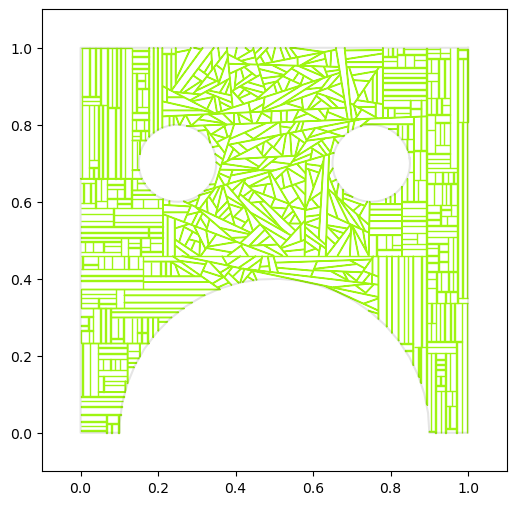

In [15]:
n = 1000
l0 = 0.005
alpha = 0.2
plt.figure(figsize=(6,6))

#define a domain
box_size = 1.0
box = Polygon([(0,0), (box_size,0), (box_size,box_size), (0,box_size)])
d1= Polygon(circle_1)
d2= Polygon(circle_2)
d3= Polygon(circle_3)

domain_polygon = box.difference(d1).difference(d2).difference(d3)


random.seed(42)
polygon_list = []
nucleation_point_list = []
angle_list = []
for i in range(n):

    ##generate a random point in the box
    nucleation_point = generate_random_point(domain_polygon, polygon_list, distance=0.01, box_size=box_size, trial=100)

    if nucleation_point is None:
        continue
    
    point = (nucleation_point.x, nucleation_point.y)
    nucleation_point_list.append(nucleation_point)

    ##generate an angle
    if 0.25 < nucleation_point.x < 0.75:
        angle = random.uniform(0, 360)
    else:
        angle = random.choice([0, 90])

    angle_list.append(angle)

    line = generate_line(point, angle, length=box_size*3, uni_direction=False)

    thickness = l0 * (1 + n)**(-alpha)

    ##generate a polygon from the line
    polygon = get_a_polygon(line, thickness=thickness)

    ##get the intersection of the polygon and the domain
    x_ing = domain_polygon.intersection(polygon)
    
    keep_polygon = None
    if not x_ing.is_empty:
        try:
            if x_ing.geom_type == 'Polygon':
                if x_ing.contains(nucleation_point) == True:
                    keep_polygon = x_ing
            elif x_ing.geom_type == 'MultiPolygon':
                for poly in x_ing.geoms:
                    if poly.contains(nucleation_point) == True:
                        keep_polygon = poly
                        break
        except:
            continue


    ##check the polygon intersection with existing polygons
    if keep_polygon != None:

        for pp in polygon_list:
            x_ing_pp = keep_polygon.difference(pp)
            if x_ing_pp.geom_type == 'Polygon' and  not x_ing_pp.equals(keep_polygon):
                if x_ing_pp.contains(nucleation_point) == True:
                    keep_polygon = x_ing_pp
            if x_ing_pp.geom_type == 'MultiPolygon':
                for poly in x_ing_pp.geoms:
                    if poly.contains(nucleation_point) == True:
                        keep_polygon =poly
                            
        polygon_list.append(keep_polygon)

        
        x,y = keep_polygon.exterior.xy
        plt.fill(x, y, alpha=1, c = '#FF644E')#, color='lightblue')

#plot domain polygon with the interior holes    
x,y = domain_polygon.exterior.xy
plt.plot(x, y, color='black', alpha = .1)
for interior in domain_polygon.interiors:
    x,y = interior.xy
    plt.plot(x, y, color='black', alpha = .1)

plt.xlim(-0.1, box_size+0.1)
plt.ylim(-0.1, box_size+0.1)
    